# Computer Vision
## Exercise Sheet 4: Greedy snake
### Erhardt Barth / Philipp Gruening / Christoph Linse / Manuel Laufer
Universität zu Lübeck, Institut für Neuro- und Bioinformatik

In case of questions, contact us via email: *{barth, gruening, linse, laufer} @inb.uni-luebeck.de*

## Note: Please insert the names of all participating students:

1. Onurcan Köken
2. Sazid Rahman Simanto
3. Mokrane Ouarezki
4. Muhammad Junaid 


In [ ]:
import sys, os
if 'google.colab' in sys.modules:
  if os.getcwd() == '/content':
    !git clone 'https://github.com/inb-luebeck/cs4250.git'
    os.chdir('cs4250')

Cloning into 'cs4250'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 87 (delta 35), reused 62 (delta 18), pack-reused 0
Unpacking objects: 100% (87/87), done.


In [ ]:
import numpy as np
from numpy.linalg import norm
import cv2
import matplotlib.pyplot as plt
%matplotlib inline  

In this exercise, a program framework is given. Add the missing parts for the implementation of a greedy 
snake at the marked sections in the code.

* Use the gradient magnitude as image term.
* Calculate the three energy terms $E_{cont}$, $E_{curv}$, and $E_{imag}$.
* Normalize the energy terms over the neighborhood to the intervall $[0,1]$.
* Estimate the point in the neighborhood, that has minimum energy.


**Hint:** Use the following equations for the implementation of the energy terms:\\
\begin{eqnarray}
E_{cont} & = & (0.5\cdot(\|p_i-p_{i-1}\|-\|p_i-p_{i+1}\|))^2 \\
E_{curv} & = & \|p_{i-1}-2 p_i+p_{i+1}\|^2 \\
E_{imag} & = & -\|\nabla I(x,y)\|
\end{eqnarray}

Comment on the difference between using $E_{cont}$ described above and the term $(\bar d-\|p_i-p_{i-1}\|)^2$ given in the lecture.


Ecurv, the one we are using in the exercise, adv: better for local calculations. The one in the lecture is better for global applications. It depends, both might be good or not. 

$E_{cont}$ term causes to minimize the distance, the average distance is used to keep the points at a certain distance. The formula that is given is not using the average distance to calculate the continuity term $E_{cont}$. When given formula is used, the contour is not a complete closed contour, but when the average distance is used it becomes a closed contour.

It is also called as elasticity; reducing the shrinking effect and also making sure that the snake control points does not bunch up in places with high image energy.

The equation we used describes the average distance between adjoining vertices.
The equation in the slides computes the total continuity energy as the total squared deviation from the average distance.

In the equation we used, it is a better approach since the computation of a continuity energy that assumes its minimum when the vertices are most evenly spaced, as described by snake to space its vertices evenly.
It is important because the next energy term, the curvature energy, relies on evenly spaced vertices.



About the differences between 2 implementations, the problem is about plotting way, the point that snake is making one complete curve and in other case it is not closed totally, so its about only plotting.

In [ ]:
def snake(img, contour, **kwargs):
    # parameter initialization
    k = contour.shape[1]
    alpha = kwargs['alpha'] * np.ones(k)
    beta = kwargs['beta'] * np.ones(k)
    gamma = kwargs['gamma'] * np.ones(k)
    
    gradient_x, gradient_y = gradient(img) # TODO: compute gradient image
    # compute gradient magnitude
    norm_image_gradient = cv2.magnitude(gradient_x, gradient_y)

    k_updated = k
    iterations = 0
    # iterate until snake stops changing
    while k_updated > k * kwargs['contour_fraction']:
        iterations = iterations + 1
        k_updated = 0
        
        # update all contour points
        for i in range(k):
            p, updated = greedy_minimization(
                norm_image_gradient, contour, i, alpha, beta, gamma, kwargs['neighborhood_size'])
            if p is not None:
                contour[:, i] = p
            # eliminate corners if required
            if iterations > kwargs['begin_corner_elim']:
                beta = corner_elimination(contour, beta, kwargs['K_threshold'])
            
            # keep track of number of updated points
            if updated:
                k_updated = k_updated + 1
        
        # display current state of snake
        print('num_updates: {}'.format(k_updated))
        plt.imshow(norm_image_gradient)
        plt.plot(contour[1, :], contour[0, :], 'r.-')
        plt.show()

In [ ]:
def greedy_minimization(norm_image_gradient, contour, i, alpha, beta, gamma, neighborhood_size):
    m, n = norm_image_gradient.shape
    k = contour.shape[1]
    w = (kwargs['neighborhood_size'] - 1.) // 2.
    d = average_distance(contour)
    updated = False

    # get previous, current, and next point in snake
    p_iminus1 = contour[:, wrap_index(i-1, k)]
    p_i = contour[:, i]
    p_iplus1 = contour[:, wrap_index(i+1, k)]

    # compute individual terms of energy functional
    p = []
    E_cont = []
    E_curv = []
    E_imag = []

    # contour shape is (2, 20)
    # shape of alpha, beta, gamma are (20,)

    # For all points in a local neighborhood, compute the energy terms
    for p_i_x in np.arange(max(0, p_i[0] - w), min(m-1, p_i[0]+w)+1):
        for p_i_y in np.arange(max(0, p_i[1]-w), min(n-1, p_i[1]+w)+1):
            # pass
            # TODO: get the respective vector
            p_array = np.array([p_i_x, p_i_y])
            p.append(p_array)
            # TODO: compute energy terms
            # The continuity term in discrete approximation ############## why in this formula? look at the slides
            E_cont.append(pow(0.5*(norm(p_array - p_iminus1) - norm(p_array - p_iplus1)), 2))
            # E_cont.append(pow(d - norm(p_array - p_iminus1), 2))
            # The smoothness term in discrete approximation
            E_curv.append(pow(norm(p_iminus1 - 2*p_array + p_iplus1), 2))
            # The image term
            E_imag.append(-norm_image_gradient[int(p_i_x), int(p_i_y)])

    if not p:
        return None, False

    # TODO: normalize individual terms of energy functional
    E_cont = np.array(E_cont)
    E_cont -= np.min(E_cont)
    E_cont /= np.max(E_cont)
    
    E_curv = np.array(E_curv)
    E_curv -= np.min(E_curv)
    E_curv /= np.max(E_curv)

    E_imag = np.array(E_imag)
    E_imag -= np.min(E_imag)
    E_imag /= np.max(E_imag)

    # compute energy functional and determine minimum
    # calculate the energy and take the min
    # new p_i_x and new p_i_y
    new_p_i = p[np.argmin(alpha[i]*E_cont + beta[i]*E_curv + gamma[i]*E_imag)]
    #new_p_i = p_i
    
    # determine if the current point of snake was moved
    if (p_i - new_p_i).sum() != 0:
        updated = True
    
    return new_p_i, updated

In [ ]:
def gradient(image):
    v = .5
    k_y = np.zeros((3, 3))
    k_y[0, 1] = -v
    k_y[2, 1] = +v

    k_x = np.zeros((3, 3))
    k_x[1, 0] = -v
    k_x[1, 2] = +v

    image = np.copy(image).astype('float32')

    gradient_x = cv2.filter2D(image, -1, k_x)
    gradient_y = cv2.filter2D(image, -1, k_y)

    return gradient_x, gradient_y

In [ ]:
def load_image_gray_normalized(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image.astype('float32')/255.

In [ ]:
def wrap_index(index, k):
    if index < 0:
        index = k - 1
    elif index > k-1:
        index = 0
    return index

In [ ]:
def average_distance(contour):
    avg_dist = 0
    n = contour.shape[1]

    for i in range(n-1):
        avg_dist = avg_dist+norm(contour[:, i] - contour[:, i+1])

    avg_dist = avg_dist+norm(contour[:, -1] - contour[:, 0])
    avg_dist = avg_dist / n

    return avg_dist

In [ ]:
def corner_elimination(contour, beta, K_threshold):
    n = contour.shape[1]
    K = []
    # compute curvature of snake at each point
    for i in range(n):
        # get previous, current, and next point in snake
        p_iminus1 = contour[:, wrap_index(i-1, n)]
        p_i = contour[:, i]
        p_iplus1 = contour[:, wrap_index(i+1, n)]
        K.append(((p_iminus1 - 2.*p_i + p_iplus1)**2.).sum())

    # determine local maxima and set beta to zero there
    for i in range(n):
        prev_is_lower = K[wrap_index(i-1, n)] < K[i]
        next_is_lower = K[i] > K[wrap_index(i+1, n)]
        thres_exceeded = K[i] > K_threshold
        if prev_is_lower and next_is_lower and thres_exceeded:
            beta[i] = 0
    
    return beta

Corner elimination: normally we are trying to make the snake smooth, but after some point it is allowed that to fit on the object and be sharp by setting beta to zero.

Test your implementation of the greedy snake on the provided test images. The files `ueb421.npy` and
`ueb422.npy` contain simple artificial test images. The file `ueb423.npy` contains a natural image. 
Besides the test images `img`, the files contain a initialization for the snake `contour`.

You need to fit the parameter dict `kwargs` to achive good results on the different images.
**What are the relevant parameters, and what is their influence on the resulting segmentation?**

**Debug Tips**: For debugging, it makes sense to test each functionality separately. For example, set alpha and beta to zero and gamma to one. The contour-points should converge to image edges. If this is not the case, something is wrong.

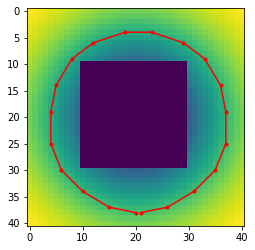

In [ ]:
# load image
input_dict = np.load('data/exercise_4/ueb422.npy', allow_pickle=True).item()
image = input_dict['img']
contour = input_dict['contour']

# show initial image & contour
plt.imshow(image)
plt.plot(contour[1, :], contour[0, :], 'r.-')
plt.show()

# set keyword arguments
kwargs = {
    'neighborhood_size': 7,
    'contour_fraction': 0.1,
    'alpha': 1.,
    'beta': 1.,
    'gamma': 1.,
    'begin_corner_elim': 10,
    'K_threshold': 1
}

# run snake
#snake(image, contour, **kwargs)

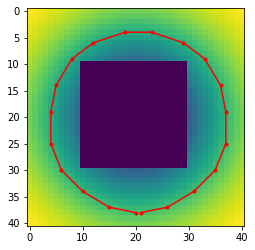

num_updates: 19


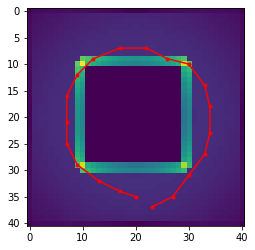

num_updates: 19


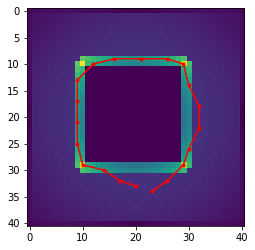

num_updates: 9


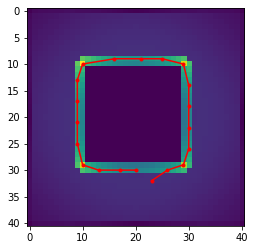

num_updates: 4


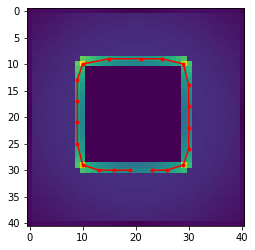

num_updates: 1


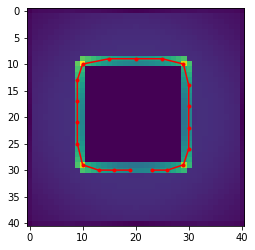

In [ ]:
# load image
input_dict = np.load('data/exercise_4/ueb422.npy', allow_pickle=True).item()
image = input_dict['img']
contour = input_dict['contour']

# show initial image & contour
plt.imshow(image)
plt.plot(contour[1, :], contour[0, :], 'r.-')
plt.show()

# set keyword arguments
kwargs = {
    'neighborhood_size': 7,
    'contour_fraction': 0.1,
    'alpha': 1.,
    'beta': 1.,
    'gamma': 1.,
    'begin_corner_elim': 10,
    'K_threshold': 1
}

# run snake
snake(image, contour, **kwargs)

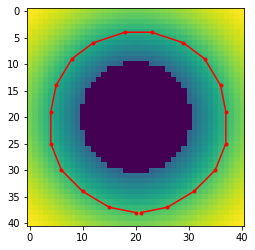

num_updates: 20


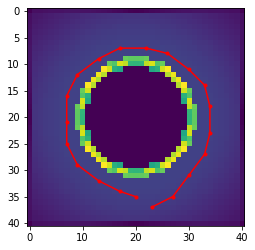

num_updates: 19


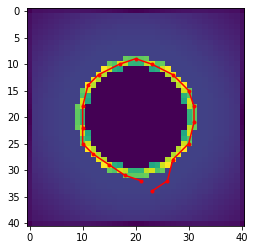

num_updates: 9


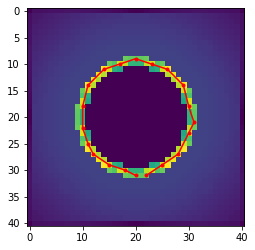

num_updates: 3


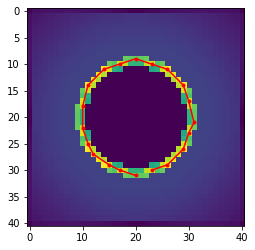

num_updates: 2


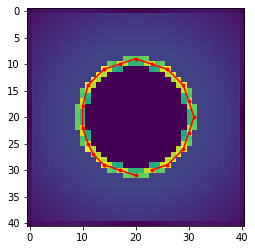

In [ ]:
# load image
input_dict = np.load('data/exercise_4/ueb421.npy', allow_pickle=True).item()
image = input_dict['img']
contour = input_dict['contour']

# show initial image & contour
plt.imshow(image)
plt.plot(contour[1, :], contour[0, :], 'r.-')
plt.show()

# set keyword arguments
kwargs = {
    'neighborhood_size': 7,
    'contour_fraction': 0.1,
    'alpha': 1.,
    'beta': 1.,
    'gamma': 1.,
    'begin_corner_elim': 10,
    'K_threshold': 1
}

# run snake
snake(image, contour, **kwargs)

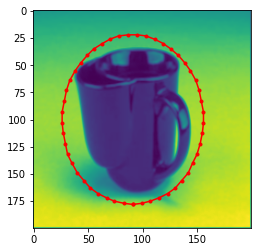

num_updates: 44


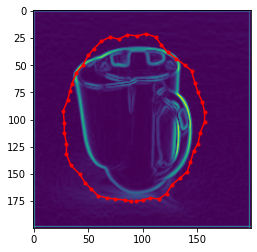

num_updates: 23


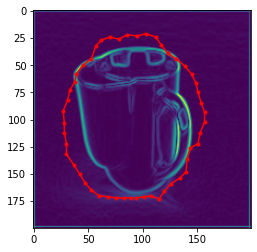

num_updates: 17


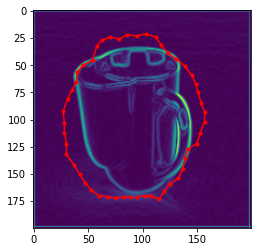

num_updates: 7


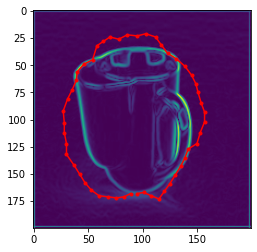

num_updates: 6


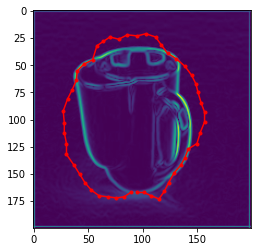

num_updates: 2


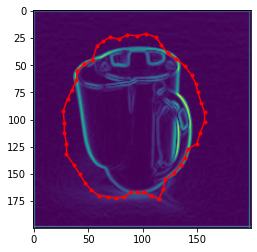

In [ ]:
# load image
input_dict = np.load('data/exercise_4/ueb423.npy', allow_pickle=True).item()
image = input_dict['img']
contour = input_dict['contour']

# show initial image & contour
plt.imshow(image)
plt.plot(contour[1, :], contour[0, :], 'r.-')
plt.show()

# set keyword arguments
kwargs = {
    'neighborhood_size': 7,
    'contour_fraction': 0.1,
    'alpha': 1.,
    'beta': 1.,
    'gamma': 1.,
    'begin_corner_elim': 10,
    'K_threshold': 1
}
# run snake
snake(image, contour, **kwargs)

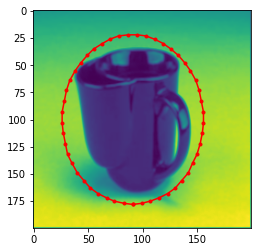

num_updates: 48


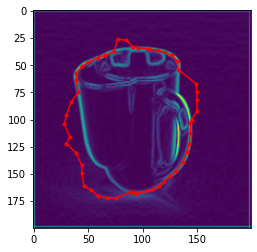

num_updates: 29


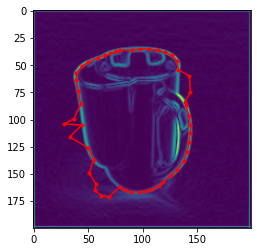

num_updates: 21


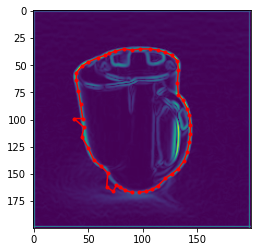

num_updates: 20


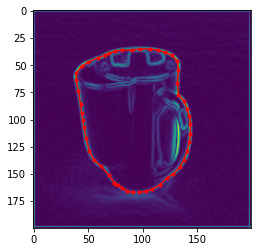

num_updates: 9


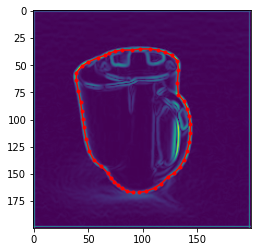

num_updates: 4


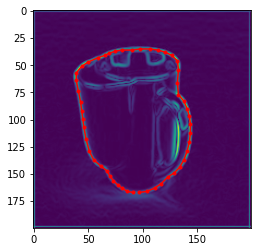

In [ ]:
# load image
input_dict = np.load('data/exercise_4/ueb423.npy', allow_pickle=True).item()
image = input_dict['img']
contour = input_dict['contour']

# show initial image & contour
plt.imshow(image)
plt.plot(contour[1, :], contour[0, :], 'r.-')
plt.show()

# set keyword arguments
kwargs = {
    'neighborhood_size': 23,
    'contour_fraction': 0.1,
    'alpha': 1.,
    'beta': 1.,
    'gamma': 1.,
    'begin_corner_elim': 10,
    'K_threshold': 1
}
# run snake
snake(image, contour, **kwargs)

References:

[1]: Elasticity: http://home.iitj.ac.in/~manpreet.bedi/btp/rmaterial/Snakes.pdf

[2]: Explanation for the question: http://what-when-how.com/biomedical-image-analysis/two-dimensional-active-contours-snakes-part-1-biomedical-image-analysis/

[3]: Minimum energy achived for the eq in slides: http://itchen.class.kmu.edu.tw/Vision/Slides/Reference/CV/nikolas.070901.pdf